In [1]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leaf-classification/train.csv.zip
/kaggle/input/leaf-classification/sample_submission.csv.zip
/kaggle/input/leaf-classification/images.zip
/kaggle/input/leaf-classification/test.csv.zip


In [2]:
import numpy as np
import random 
import pandas as pd
import tensorflow as tf
import cv2
import gc, glob
import matplotlib #image save
import matplotlib.pyplot as plt #plotting
from matplotlib.pyplot import imshow #Show images
from PIL import Image, ImageFont, ImageDraw
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, Input
from keras.optimizers import SGD
from tensorflow import keras
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def reset_keras():
    tf.keras.backend.clear_session #This clears the GPU session
    gc.collect()
reset_keras() 


# Load Data

In [4]:
train = pd.read_csv('/kaggle/input/leaf-classification/train.csv.zip')
test = pd.read_csv('/kaggle/input/leaf-classification/test.csv.zip')

In [5]:
train

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.000000,0.000000,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.000000,0.000000,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.000000,0.000000,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.000000,0.000000,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,1575,Magnolia_Salicifolia,0.060547,0.119140,0.007812,0.003906,0.000000,0.148440,0.017578,0.0,...,0.242190,0.000000,0.034180,0.000000,0.010742,0.000000,0.000000,0.000000,0.000000,0.018555
986,1578,Acer_Pictum,0.001953,0.003906,0.021484,0.107420,0.001953,0.000000,0.000000,0.0,...,0.170900,0.000000,0.018555,0.000000,0.011719,0.000000,0.000000,0.000977,0.000000,0.021484
987,1581,Alnus_Maximowiczii,0.001953,0.003906,0.000000,0.021484,0.078125,0.003906,0.007812,0.0,...,0.004883,0.000977,0.004883,0.027344,0.016602,0.007812,0.000000,0.027344,0.000000,0.001953
988,1582,Quercus_Rubra,0.000000,0.000000,0.046875,0.056641,0.009766,0.000000,0.000000,0.0,...,0.083008,0.030273,0.000977,0.002930,0.014648,0.000000,0.041992,0.000000,0.001953,0.002930


In [6]:
len(train['species'].unique())# number of species

99

In [7]:
y_train = train['species']
y_train

In [9]:
id = test.iloc[:,0]
id

In [11]:
train.shape, test.shape

((990, 194), (594, 193))

# Unzip Image file

In [12]:
import zipfile

def unzip_file(zip_file_path, extract_to_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
        
unzip_file('/kaggle/input/leaf-classification/images.zip', '/kaggle/working')        

# Create Image filepath

In [13]:
image_size = 64

image_dir = '/kaggle/working/images/'
image_file = glob.glob('image/*.jpg')
train['image_path']= image_dir + train['id'].astype(str)+'.jpg'
test['image_path']= image_dir + test['id'].astype(str)+'.jpg'

# Image Loading and Resizing

In [14]:
reset_keras()
total_train = []
total_test = []

count = 0
for i in range(len(train['image_path'])):#loop through the dataframe
    tmp=cv2.imread(train.image_path[i]) #read image from filepath
    n_train = total_train.append(cv2.resize(tmp,(image_size, image_size)))#resize image
    count +=1
    
count = 0
for i in range(len(test['image_path'])):
    tmp=cv2.imread(test.image_path[i])
    n_test = total_test.append(cv2.resize(tmp,(image_size, image_size)))
    count +=1
    

# Imager Visualization 

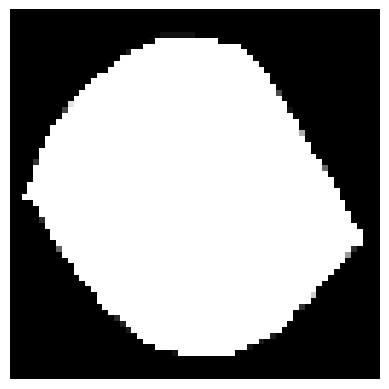

In [45]:
myarray = np.uint8(total_train)[5, :, :]#Convert the list of training images to a NumPy array, I choose number 5 image
plt.imshow(myarray, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.axis('off')  
plt.show()

# Hyperparameter 

In [16]:
batch = 32
epochs = 200
random.seed(88)

# Data preprocessing

In [17]:
#Xtrain and Xtest  for image
X_train_image = np.reshape(total_train, (len(total_train), image_size, image_size,3))# reshape to the required dimension for the model 
X_test_image = np.reshape(total_test, (len(total_test), image_size, image_size,3))

In [19]:
#flat file preprocessing
#X train for words
X_train = train
X_train = X_train.drop(columns=['id', 'species', 'image_path'])

In [20]:
X_train

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.000000,0.000000,0.004883,0.000000,0.025391
1,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,0.007812,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.000000,0.000000,0.000977,0.039062,0.022461
2,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,0.044922,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.000000,0.000000,0.000000,0.020508,0.002930
3,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,0.017578,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.000000,0.000000,0.017578,0.000000,0.047852
4,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,0.005859,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0.060547,0.119140,0.007812,0.003906,0.000000,0.148440,0.017578,0.0,0.001953,0.042969,...,0.242190,0.000000,0.034180,0.000000,0.010742,0.000000,0.000000,0.000000,0.000000,0.018555
986,0.001953,0.003906,0.021484,0.107420,0.001953,0.000000,0.000000,0.0,0.029297,0.003906,...,0.170900,0.000000,0.018555,0.000000,0.011719,0.000000,0.000000,0.000977,0.000000,0.021484
987,0.001953,0.003906,0.000000,0.021484,0.078125,0.003906,0.007812,0.0,0.003906,0.000000,...,0.004883,0.000977,0.004883,0.027344,0.016602,0.007812,0.000000,0.027344,0.000000,0.001953
988,0.000000,0.000000,0.046875,0.056641,0.009766,0.000000,0.000000,0.0,0.037109,0.001953,...,0.083008,0.030273,0.000977,0.002930,0.014648,0.000000,0.041992,0.000000,0.001953,0.002930


In [21]:
y_train = pd.DataFrame(y_train)#convert species variable to dummies variables so there's 99 output
y_train = pd.get_dummies(y_train)

In [22]:
y_train

,species_Acer_Capillipes,species_Acer_Circinatum,species_Acer_Mono,species_Acer_Opalus,species_Acer_Palmatum,species_Acer_Pictum,species_Acer_Platanoids,species_Acer_Rubrum,species_Acer_Rufinerve,species_Acer_Saccharinum,...,species_Salix_Fragilis,species_Salix_Intergra,species_Sorbus_Aria,species_Tilia_Oliveri,species_Tilia_Platyphyllos,species_Tilia_Tomentosa,species_Ulmus_Bergmanniana,species_Viburnum_Tinus,species_Viburnum_x_Rhytidophylloides,species_Zelkova_Serrata
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
986,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
987,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
988,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
X_test = test
X_test = X_test.drop(columns=['id','image_path'])

In [24]:
X_test

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.000000,0.005859,0.023438,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.000000,0.033203,0.023438,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.000000,0.011719,0.005859,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.000000,0.003906,0.001953,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.000000,0.005859,0.000000,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,0.000000,0.000000,0.003906,0.015625,0.041016,0.000000,0.017578,0.000000,0.005859,0.013672,...,0.098633,0.000000,0.004883,0.000000,0.003906,0.0,0.0,0.018555,0.000000,0.000977
590,0.000000,0.003906,0.003906,0.005859,0.017578,0.000000,0.017578,0.005859,0.000000,0.005859,...,0.012695,0.004883,0.004883,0.002930,0.009766,0.0,0.0,0.090820,0.000000,0.016602
591,0.017578,0.029297,0.015625,0.013672,0.003906,0.015625,0.025391,0.000000,0.000000,0.009766,...,0.073242,0.000000,0.028320,0.000000,0.001953,0.0,0.0,0.000000,0.042969,0.006836
592,0.013672,0.009766,0.060547,0.025391,0.035156,0.025391,0.039062,0.000000,0.003906,0.023438,...,0.003906,0.000000,0.000977,0.000000,0.011719,0.0,0.0,0.000000,0.011719,0.018555


In [25]:
print(X_train_image.shape,X_train.shape,y_train.shape)

(990, 64, 64, 3) (990, 192) (990, 99)


## Model 1

I used my previous code from the discussion to build the model. The model has multi-inputs and a single output. 

In [26]:
def build_feature_model(inputs): # model for the features
    # Hyperparameters
    width = 64
    depth = 3
    activation = "relu"
    dropout = 0.1

    # Initial dense layer
    x = keras.layers.Dense(width, activation=activation)(inputs)

    # Building the model with multiple dense, dropout, and batch normalization layers
    for i in range(depth):
        if i == 0:
            x = inputs  # No need to reassign inputs in the first iteration
        x = keras.layers.Dense(width, activation=activation)(x)
        x = keras.layers.Dropout(dropout)(x)
        if (i + 1) % 3 == 0:
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Concatenate()([x, inputs])

    return x

In [27]:
#a block of convolutional layers followed by max pooling in a neural network
def block(x, filters, kernel_size, repetitions, pool_size=2, strides=2):
    for i in range(repetitions):
        x = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size, strides)(x)
    return x

In [28]:
def get_model():
    # Input layers
    input_1 = Input(shape=(image_size,image_size,3))
    input_2 = Input(shape=(X_train.shape[1]))


    # Image branch
    image_x = block(input_1, 8, 3, 2)
    image_x = block(image_x, 16, 3, 2)
    image_x = block(image_x, 32, 3, 2)
    image_x = block(image_x, 64, 3, 2)
    image_x = block(image_x, 128, 3, 2)
    image_x = tf.keras.layers.GlobalAveragePooling2D()(image_x)

    # Feature branch (assuming build_feature_model is defined elsewhere)
    feature_x = build_feature_model(input_2)

    # Concatenate image and feature branches
    x = tf.keras.layers.Concatenate(axis=1)([image_x, feature_x])

    # Output layer
    output=Dense(99,activation='relu')(x)
    output=Dense(99,activation='softmax')(output)# Dense 99 because there's 99 categories

    # Create and return the model
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)
    return model

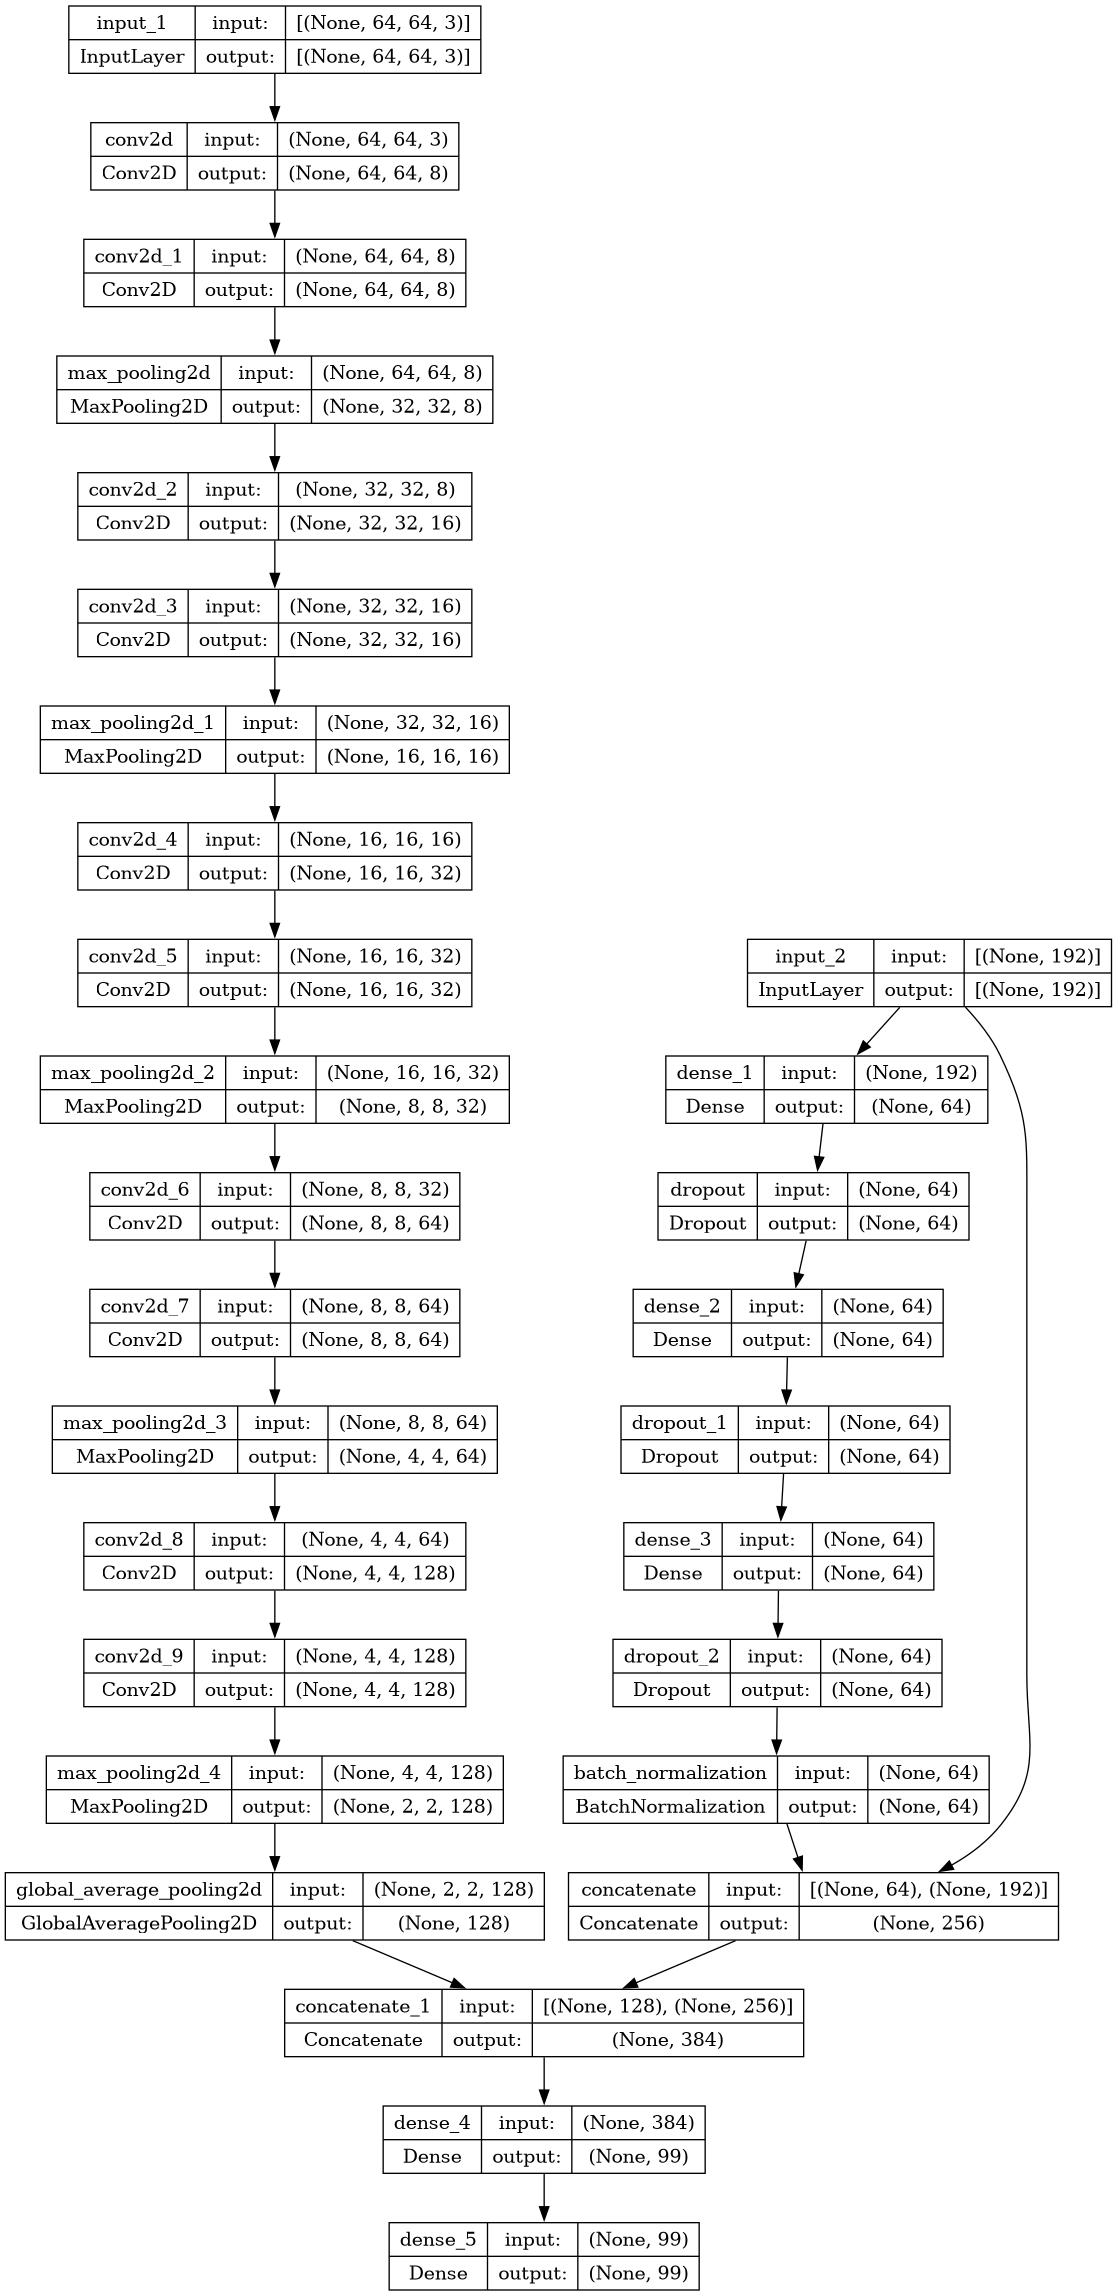

In [29]:
reset_keras()
model1 = get_model()
tf.keras.utils.plot_model(model1, show_shapes=True)

In [30]:
reset_keras() #compile model
opt= tf.keras.optimizers.Adam(lr=0.0001)
model1.compile(loss=tf.keras.losses.categorical_crossentropy, 
          optimizer=opt, metrics=['categorical_accuracy', 'categorical_crossentropy'])# change the matrics to categorical_accuracy because we have 99 categories
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 8)            224       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 8)            584       ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 8)            0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [31]:
# train model
reset_keras()
history1=model1.fit(
              x=[X_train_image, X_train],y=y_train, batch_size=batch,verbose=1,epochs=100, validation_split=.2)            



Epoch 1/100
25/25 [==============================] - 15s 48ms/step - loss: 4.6220 - categorical_accuracy: 0.0189 - categorical_crossentropy: 4.6220 - val_loss: 4.5966 - val_categorical_accuracy: 0.0101 - val_categorical_crossentropy: 4.5966
Epoch 2/100
25/25 [==============================] - 0s 12ms/step - loss: 4.4135 - categorical_accuracy: 0.0619 - categorical_crossentropy: 4.4135 - val_loss: 4.6182 - val_categorical_accuracy: 0.0000e+00 - val_categorical_crossentropy: 4.6182
Epoch 3/100
25/25 [==============================] - 0s 12ms/step - loss: 4.0698 - categorical_accuracy: 0.1124 - categorical_crossentropy: 4.0698 - val_loss: 4.3654 - val_categorical_accuracy: 0.0101 - val_categorical_crossentropy: 4.3654
Epoch 4/100
25/25 [==============================] - 0s 12ms/step - loss: 3.4456 - categorical_accuracy: 0.1806 - categorical_crossentropy: 3.4456 - val_loss: 4.2047 - val_categorical_accuracy: 0.0556 - val_categorical_crossentropy: 4.2047
Epoch 5/100
25/25 [================

# History plot

In [46]:
def plot_accuracy_and_loss(train_model, model_name):
    hist = train_model.history
    acc = hist['categorical_accuracy']
    val_acc = hist['val_categorical_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(16,4))
    ax[0].plot(epochs, acc, 'g', label='categorical_accuracy', marker='D', mec='b', ms='3')
    ax[0].plot(epochs, val_acc, 'r', label='val_categorical_accuracyy', marker='o', mec='yellow', ms='3')
    ax[0].set_title('{} Training and validation accuracy'.format(model_name))
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss', marker='D', mec='b', ms='3')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss', marker='o', mec='yellow', ms='3')
    ax[1].set_title('{} Training and validation accuracy'.format(model_name))
    ax[1].legend()
    plt.show()

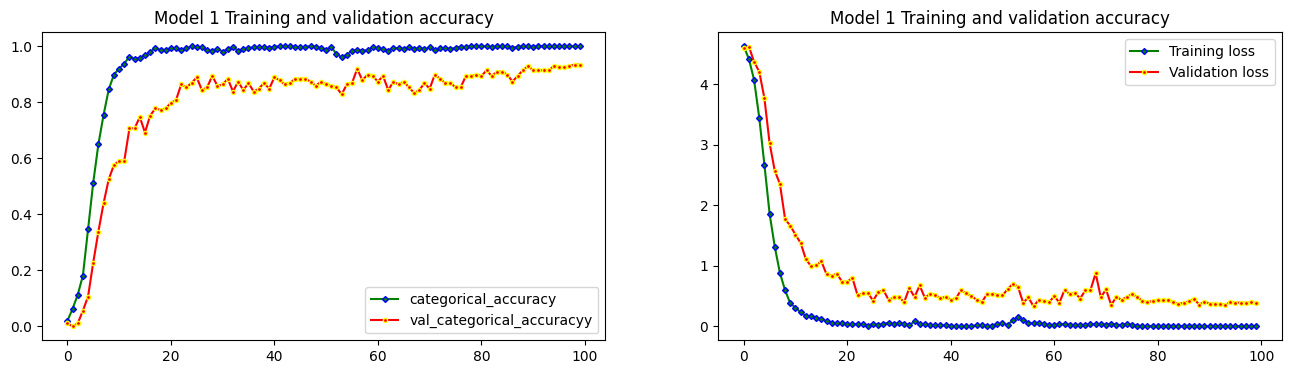

In [47]:
history1_plot = plot_accuracy_and_loss(history1, 'Model 1')

# Model 2 (professor's model)

I want to compare my model with professor's model to measure the performance. 

In [34]:
reset_keras()

input_1 = Input(shape=(image_size,image_size,3))
input_2 = Input(shape=(X_train.shape[1]))


x0=tf.keras.applications.EfficientNetB6(include_top=False, weights='imagenet', input_shape=(image_size,image_size, 3))(input_1)
x0=layers.Flatten()(x0)
x0=layers.Dense(99, activation='softmax')(x0)

x1=Dense(200, name="Dense_200_NN")(input_2)
x1=Dropout(.5, name="Dropout_0.5_NN")(x1)
x1=Dense(150, name="Dense_150")(x1)
x1=Dropout(.3, name="Dropout_0.3_NN")(x1)
x1=Dense(99, name="Dense_99")(x1)
x1=Dropout(.2, name="Dropout_0.2")(x1)

concat=tf.keras.layers.concatenate([x0,x1], axis=-1)

output=Dense(99,activation='relu')(concat)
output=Dense(99,activation='softmax')(output)



model2=tf.keras.Model(inputs=[input_1, input_2], outputs=output)

165234480/165234480 [==============================] - 1s 0us/step


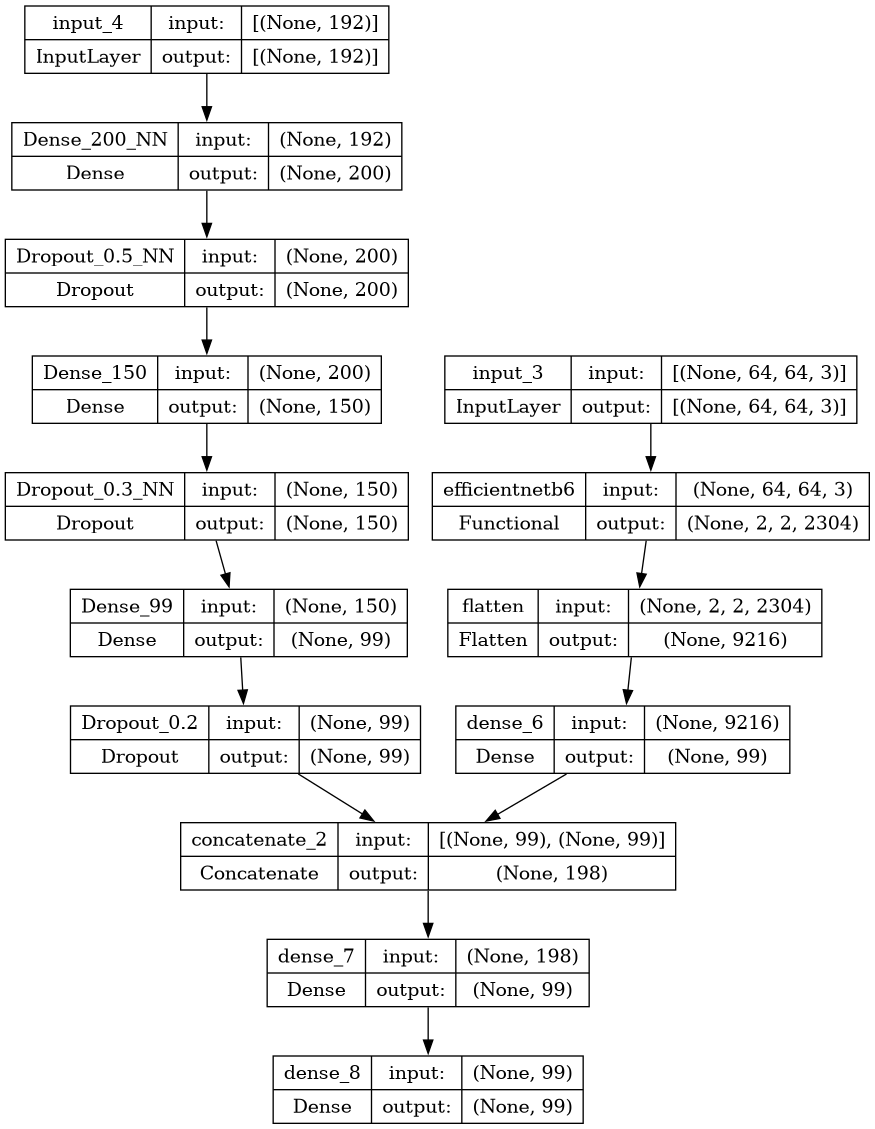

In [35]:
tf.keras.utils.plot_model(model2, show_shapes=True)

In [36]:
#compile model2
reset_keras()
opt= tf.keras.optimizers.Adam(lr=0.0001)
model2.compile(loss=tf.keras.losses.categorical_crossentropy, 
          optimizer=opt, metrics=['categorical_accuracy', 'categorical_crossentropy'])# change the matrics to categorical_accuracy because we have 99 categories
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 192)]                0         []                            
                                                                                                  
 Dense_200_NN (Dense)        (None, 200)                  38600     ['input_4[0][0]']             
                                                                                                  
 Dropout_0.5_NN (Dropout)    (None, 200)                  0         ['Dense_200_NN[0][0]']        
                                                                                                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                            

In [37]:
#train model2
reset_keras()
history2=model2.fit(
              x=[X_train_image, X_train],y=y_train, batch_size=batch,verbose=1,epochs=100, validation_split=.2)       

Epoch 1/100


2023-12-18 02:29:46.850220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/efficientnetb6/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 134s 383ms/step - loss: 4.5755 - categorical_accuracy: 0.0354 - categorical_crossentropy: 4.5755 - val_loss: 4.5618 - val_categorical_accuracy: 0.0606 - val_categorical_crossentropy: 4.5618
Epoch 2/100
25/25 [==============================] - 3s 130ms/step - loss: 4.4830 - categorical_accuracy: 0.0732 - categorical_crossentropy: 4.4830 - val_loss: 4.4773 - val_categorical_accuracy: 0.0556 - val_categorical_crossentropy: 4.4773
Epoch 3/100
25/25 [==============================] - 3s 133ms/step - loss: 4.2112 - categorical_accuracy: 0.0947 - categorical_crossentropy: 4.2112 - val_loss: 4.1252 - val_categorical_accuracy: 0.0657 - val_categorical_crossentropy: 4.1252
Epoch 4/100
25/25 [==============================] - 3s 128ms/step - loss: 3.5904 - categorical_accuracy: 0.1376 - categorical_crossentropy: 3.5904 - val_loss: 3.5552 - val_categorical_accuracy: 0.1212 - val_categorical_crossentropy: 3.5552
Epoch 5/100
25/25 [===========================

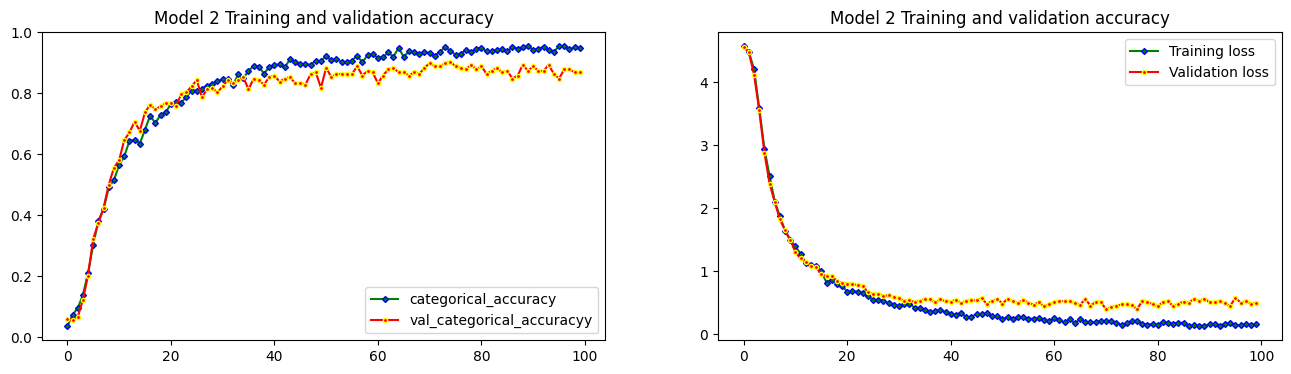

In [48]:
history2_plot = plot_accuracy_and_loss(history2, 'Model 2')
history2_plot

# Predict

In [39]:
submission_example = pd.read_csv('/kaggle/input/leaf-classification/sample_submission.csv.zip')

In [40]:
#model1 prediction
predict1=model1.predict([X_test_image,X_test])# predict both the image and the text
pred1=np.squeeze(predict1)

probs1=pd.DataFrame(pred1)
temp1=pd.DataFrame(test.id)
submission1=pd.concat([temp1, probs1], axis=1)
submission1.columns = submission_example.columns
submission1.to_csv("submission1.csv",index=False)

19/19 [==============================] - 0s 10ms/step


In [41]:
#model2 prediction
predict2=model2.predict([X_test_image,X_test])
pred2=np.squeeze(predict2)

probs2=pd.DataFrame(pred2)
temp2=pd.DataFrame(test.id)
submission2=pd.concat([temp2, probs2], axis=1)
submission2.columns = submission_example.columns
submission2.to_csv("submission2.csv",index=False)

19/19 [==============================] - 6s 69ms/step


The submission score for the model1 is higher than model2 but I believe if I trained on seperate python notebook the result will be different. 